# Transfer Learning with Pre-trained Models

**Objective:** Fine-tune a pre-trained EfficientNetB0 model for cyanobacteria toxicity classification:
- Load and process image data from splits
- Configure and initialize pre-trained model
- Train with transfer learning approach
- Save and evaluate model performance

## 1. Imports, Config & Seeds

In [2]:
import os
import random
import shutil
import subprocess
from datetime import date

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks
from tensorflow.keras.applications import EfficientNetB0

from src.config_utils import load_config
from src.data_loader import load_from_splits

# Load finetune_efficientnetb0 learning configuration
cfg = load_config('../configs/config_finetune_efficientnetb0.yaml')

# Set seeds for reproducibility
random.seed(cfg['seed'])
np.random.seed(cfg['seed'])
tf.random.set_seed(cfg['seed'])

# Extract config parameters
DATA_PROCESSED = cfg['data']['processed_dir']
IMG_SIZE = tuple(cfg['preprocessing']['target_size'])
BATCH_SIZE = cfg['training']['batch_size']
EPOCHS = cfg['training']['epochs']
LR = float(cfg['training']['learning_rate'])
EARLYSTOP_CFG = cfg['training']['early_stopping']
MODEL_TYPE = cfg['training']['model_type']

## 2. Setup Run ID & Output Directories

In [3]:
# Generate unique run ID from date + git hash
today = date.today().isoformat()
commit = subprocess.check_output(['git','rev-parse','--short','HEAD']).decode().strip()
run_id = f"{today}_{commit}"

# Create output directories
CKPT_DIR = os.path.join('..','outputs','checkpoints', 'all', 'finetune_efficientnetb0')
CFG_OUT = os.path.join('..','outputs','configs','all')
FIG_OUT = os.path.join('..','outputs','figures', 'all', 'finetune_efficientnetb0')
LOG_OUT = os.path.join('..','outputs','logs', 'all','finetune_efficientnetb0')

for d in (CKPT_DIR, CFG_OUT, FIG_OUT, LOG_OUT):
    os.makedirs(d, exist_ok=True)

print(f"Run ID: {run_id}")

Run ID: 2025-07-27_3319866


## 3. Data Loading & Preprocessing

In [4]:
# Load training and validation splits
train_ds, class_indices = load_from_splits(
    '../splits/all/finetune_efficientnetb0/train.txt',
    BATCH_SIZE,
    IMG_SIZE
)
val_ds, _ = load_from_splits(
    '../splits/all/finetune_efficientnetb0/val.txt',
    BATCH_SIZE,
    IMG_SIZE
)
num_classes = len(class_indices)
print(f"Classes: {class_indices}")

Classes: {'non_toxic': 0, 'toxic': 1}


## 4. Model Architecture

In [5]:
def build_transfer_model(model_type: str, img_size: tuple, num_classes: int) -> models.Model:
    """
    Build a finetune_efficientnetb0 learning model with a pre-trained backbone

    Args:
        model_type: Name of the backbone architecture
        img_size: Input image dimensions (height, width)
        num_classes: Number of output classes

    Returns:
        Compiled Keras model
    """
    # Select backbone architecture
    if model_type == 'efficientnetb0':
        base = EfficientNetB0(
            weights='imagenet',
            include_top=False,
            input_shape=img_size+(3,)
        )
    elif model_type == 'mobilenetv2':
        from tensorflow.keras.applications import MobileNetV2
        base = MobileNetV2(
            weights='imagenet',
            include_top=False,
            input_shape=img_size+(3,)
        )
    else:
        raise ValueError(f"Unknown model type: {model_type}")

    # Freeze backbone layers
    base.trainable = False

    # Build classification head
    inputs = tf.keras.Input(shape=img_size+(3,))
    x = base(inputs, training=False)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    model = models.Model(inputs, outputs, name=f"transfer_{model_type}")

    return model

# Build and compile model
model = build_transfer_model(MODEL_TYPE, IMG_SIZE, num_classes)
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=LR),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "transfer_efficientnetb0"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 4, 4, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 2)              │         2,562 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,052,133 (15.46 MB)

 Trainable params: 2,562 (10.01 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

## 5. Training

In [6]:
# Setup callbacks
ckpt_path = os.path.join(CKPT_DIR, f"{run_id}_transfer_{MODEL_TYPE}.keras")
callbacks_list = [
    callbacks.ModelCheckpoint(
        ckpt_path,
        save_best_only=True,
        monitor="val_accuracy",
        mode="max"
    ),
    callbacks.EarlyStopping(**EARLYSTOP_CFG)
]

# Train model
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=callbacks_list
)

Epoch 1/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 6s 211ms/step - accuracy: 0.4777 - loss: 0.7274 - val_accuracy: 0.6364 - val_loss: 0.6731
Epoch 2/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 135ms/step - accuracy: 0.5709 - loss: 0.6954 - val_accuracy: 0.6364 - val_loss: 0.6630
Epoch 3/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 128ms/step - accuracy: 0.5370 - loss: 0.7159 - val_accuracy: 0.6364 - val_loss: 0.6629
Epoch 4/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 128ms/step - accuracy: 0.5269 - loss: 0.7149 - val_accuracy: 0.6364 - val_loss: 0.6637
Epoch 5/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 130ms/step - accuracy: 0.5368 - loss: 0.7192 - val_accuracy: 0.6364 - val_loss: 0.6614
Epoch 6/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 131ms/step - accuracy: 0.5058 - loss: 0.7209 - val_accuracy: 0.6364 - val_loss: 0.6608


## 6. Results & Visualization

Saved learning curves to: ../outputs/figures/all/finetune_efficientnetb0/2025-07-27_3319866_curves_transfer.png
Saved metrics to: ../outputs/logs/all/finetune_efficientnetb0/2025-07-27_3319866_metrics_transfer.txt


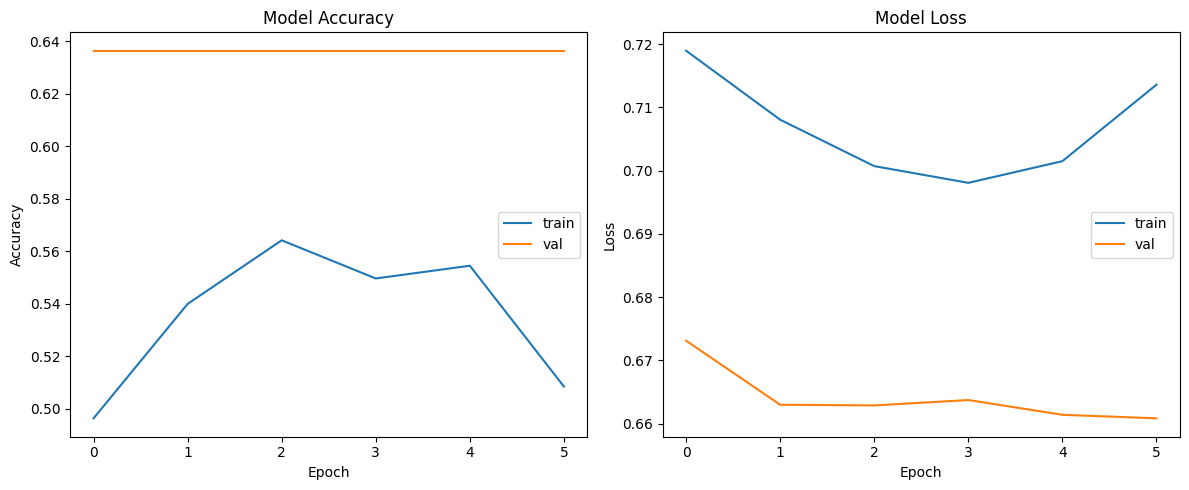

In [7]:
def save_training_artifacts(history, run_id: str, model_type: str):
    """
    Save config, learning curves and metrics

    Args:
        history: Training history
        run_id: Unique run identifier
        model_type: Model architecture name
    """
    # Save config
    dst_cfg = os.path.join(CFG_OUT, f"{run_id}_config_transfer.yaml")
    shutil.copy('../configs/config_finetune_efficientnetb0.yaml', dst_cfg)

    # Plot learning curves
    plt.figure(figsize=(12,5))

    # Accuracy
    plt.subplot(1,2,1)
    plt.plot(history.history['accuracy'], label='train')
    plt.plot(history.history['val_accuracy'], label='val')
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend()

    # Loss
    plt.subplot(1,2,2)
    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='val')
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()

    # Save plot
    fig_path = os.path.join(FIG_OUT, f"{run_id}_curves_transfer.png")
    plt.tight_layout()
    plt.savefig(fig_path, dpi=300, bbox_inches='tight')
    print(f"Saved learning curves to: {fig_path}")

    # Save metrics
    metrics_path = os.path.join(LOG_OUT, f"{run_id}_metrics_transfer.txt")
    with open(metrics_path, 'w') as f:
        for metric, values in history.history.items():
            f.write(f"{metric}: {values}\n")
    print(f"Saved metrics to: {metrics_path}")

# Save results
save_training_artifacts(history, run_id, MODEL_TYPE)

## 7. Model Evaluation

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 716ms/step


2025-07-27 19:09:48.312291: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


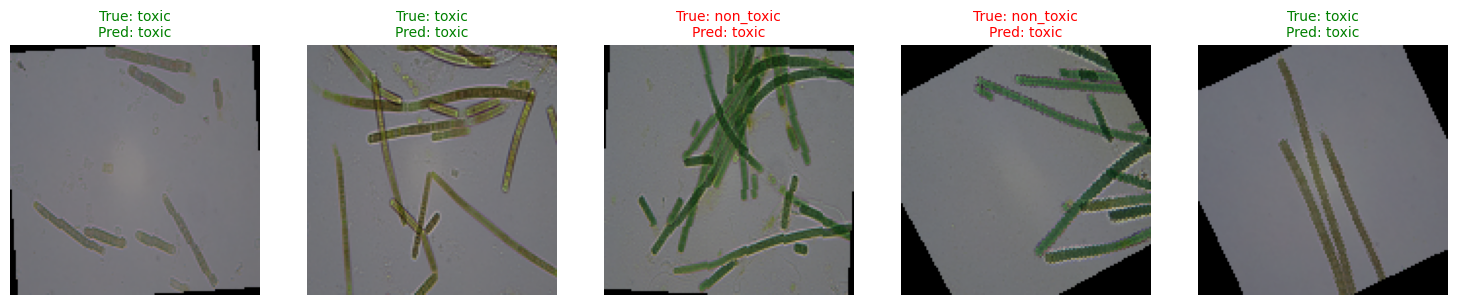

In [8]:
def visualize_predictions(model, dataset, class_indices, num_samples=5):
    """
    Visualize model predictions on sample images

    Args:
        model: Trained model
        dataset: Validation dataset
        class_indices: Dictionary mapping class indices to labels
        num_samples: Number of samples to visualize
    """
    plt.figure(figsize=(15,3))

    for images, labels in dataset.take(1):
        predictions = model.predict(images)

        for i in range(num_samples):
            plt.subplot(1, num_samples, i+1)
            plt.imshow(images[i])

            true_class = list(class_indices.keys())[labels.numpy()[i]]
            pred_class = list(class_indices.keys())[np.argmax(predictions[i])]

            color = 'green' if true_class == pred_class else 'red'
            plt.title(f"True: {true_class}\nPred: {pred_class}",
                     color=color,
                     fontsize=10)
            plt.axis('off')

    plt.tight_layout()
    plt.show()

# Visualize sample predictions
visualize_predictions(model, val_ds, class_indices)